## Liver Cirrhosis Segmentation using SynergyNet (2D MRI) ##
Dataset: Cirrhosis_T2_2D

Model: ResNet18-based Encoder + TransposedConv Decoder

Task: Binary segmentation (mask liver region from MRI slices)


In [1]:
!ls -lh /content/



total 4.0K
drwxr-xr-x 1 root root 4.0K Jul 10 13:35 sample_data


In [3]:
!file /content/Cirrhosis_T2_2D.zip

/content/Cirrhosis_T2_2D.zip: Zip archive data, at least v1.0 to extract, compression method=store


In [5]:
!unzip -q /content/Cirrhosis_T2_2D.zip -d /content


In [6]:
!find /content/Cirrhosis_T2_2D -maxdepth 2 -type d | sort | head

!ls -R /content/Cirrhosis_T2_2D | head


/content/Cirrhosis_T2_2D
/content/Cirrhosis_T2_2D/test
/content/Cirrhosis_T2_2D/test/58
/content/Cirrhosis_T2_2D/test/60
/content/Cirrhosis_T2_2D/test/62
/content/Cirrhosis_T2_2D/test/63
/content/Cirrhosis_T2_2D/test/64
/content/Cirrhosis_T2_2D/test/65
/content/Cirrhosis_T2_2D/test/68
/content/Cirrhosis_T2_2D/test/69
/content/Cirrhosis_T2_2D:
test
train
valid

/content/Cirrhosis_T2_2D/test:
58
60
62
63


Train Patients:
  Patient: 152
    Images: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/152/images
    Masks: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/152/masks
  Patient: 355
    Images: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/355/images
    Masks: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/355/masks
  Patient: 369
    Images: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/369/images
    Masks: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/369/masks
  Patient: 158
    Images: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/158/images
    Masks: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/158/masks
  Patient: 297
    Images: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/297/images
    Masks: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/297/masks
  Patient: 254
    Images: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/254/images
    Masks: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/254/masks
  Patient: 327
    Images: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


Train Dataset Size: 5428
Validation Dataset Size: 674
Test  Dataset Size: 664
Train Loader Batches: 340
Validation Loader Batches: 43
Test Loader Batches: 83
Epoch 1/50
  Train Loss: 0.1163 - Val Loss: 0.0751
  Train Dice: 0.1626 - Val Dice: 0.7159
  Train Precision: 0.8662 - Val Precision: 0.8568
  Train Recall: 0.1688 - Val Recall: 0.8029
Epoch 2/50
  Train Loss: 0.0600 - Val Loss: 0.0495
  Train Dice: 0.7244 - Val Dice: 0.7818
  Train Precision: 0.8749 - Val Precision: 0.9017
  Train Recall: 0.8163 - Val Recall: 0.8417
Epoch 3/50
  Train Loss: 0.0462 - Val Loss: 0.0437
  Train Dice: 0.7797 - Val Dice: 0.8102
  Train Precision: 0.8946 - Val Precision: 0.9201
  Train Recall: 0.8621 - Val Recall: 0.8599
Epoch 4/50
  Train Loss: 0.0394 - Val Loss: 0.0443
  Train Dice: 0.8095 - Val Dice: 0.8200
  Train Precision: 0.9075 - Val Precision: 0.9351
  Train Recall: 0.8841 - Val Recall: 0.8482
Epoch 5/50
  Train Loss: 0.0344 - Val Loss: 0.0373
  Train Dice: 0.8352 - Val Dice: 0.8495
  Train Pre

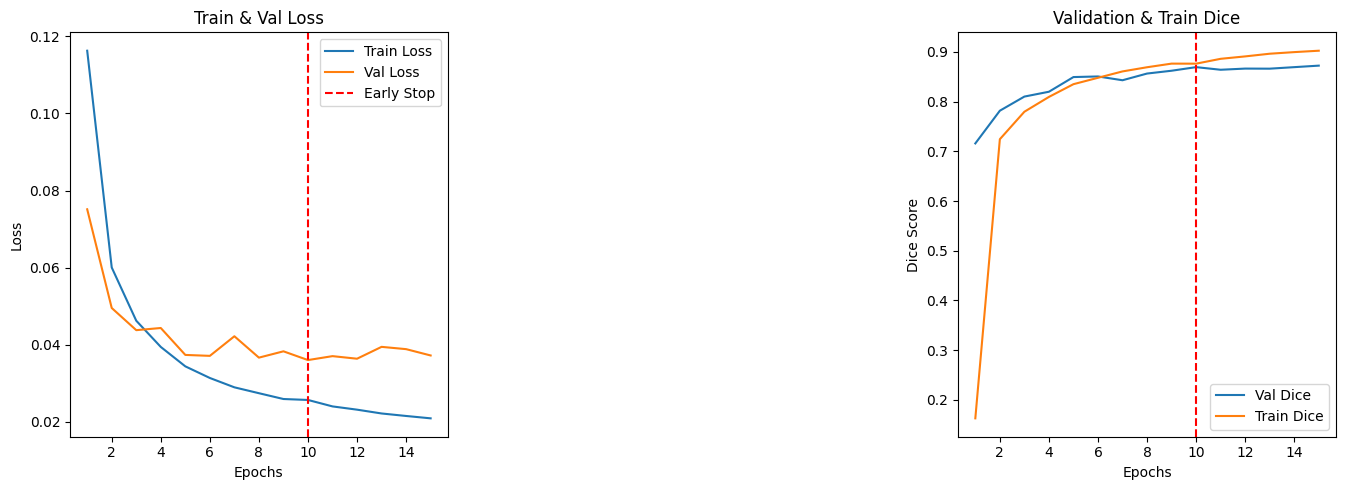


Evaluating on Test Data...
Test Results:
  Precision: 0.8922
  Recall:    0.9125
  Dice Score: 0.8267


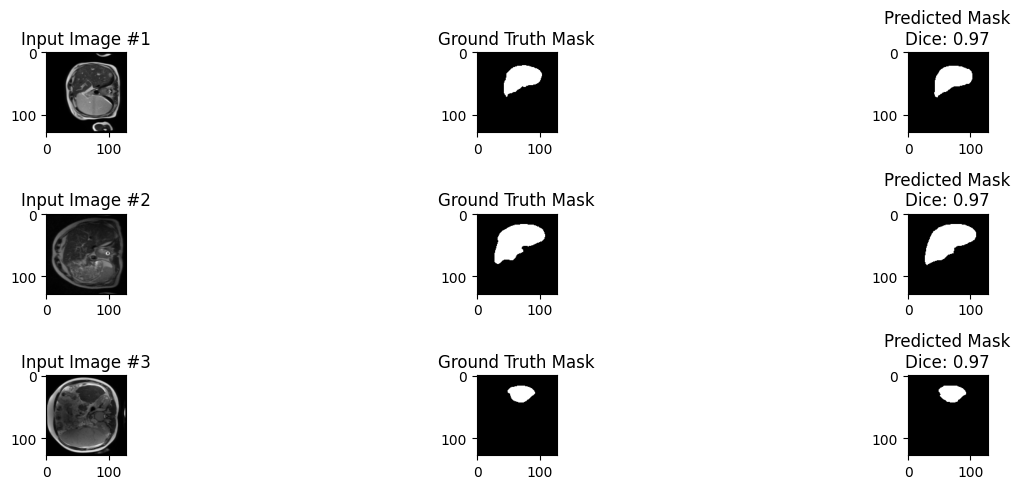

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.models import ResNet18_Weights
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
#       DATASET SETUP
# -------------------------
base_dir = '/content/Cirrhosis_T2_2D'

def get_patient_dirs(base_dir, phase):
    phase_dir = os.path.join(base_dir, phase)
    if not os.path.exists(phase_dir):
        raise FileNotFoundError(f"Directory {phase_dir} does not exist.")
    patient_dirs = [
        os.path.join(phase_dir, patient)
        for patient in os.listdir(phase_dir)
        if os.path.isdir(os.path.join(phase_dir, patient))
    ]
    return patient_dirs

# Debugging: Print Folder Structure for 'train', 'valid', 'test'
for phase in ['train', 'valid', 'test']:
    try:
        patient_dirs = get_patient_dirs(base_dir, phase)
        print(f"{phase.capitalize()} Patients:")
        for patient_dir in patient_dirs:
            img_dir = os.path.join(patient_dir, 'images')
            mask_dir = os.path.join(patient_dir, 'masks')
            print(f"  Patient: {os.path.basename(patient_dir)}")
            print(f"    Images: {img_dir}")
            print(f"    Masks: {mask_dir}")
    except FileNotFoundError as e:
        print(e)

# Define a transform for both images and masks
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# -------------------------
#   DATASET CLASS
# -------------------------
class LiverSegmentationDataset(Dataset):
    def __init__(self, base_dir, phase, transform=None):
        """
        Collects all image/mask file paths from the specified phase directory.
        """
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        patient_dirs = get_patient_dirs(base_dir, phase)
        for patient_dir in patient_dirs:
            img_dir = os.path.join(patient_dir, 'images')
            mask_dir = os.path.join(patient_dir, 'masks')

            img_files = sorted(os.listdir(img_dir))
            mask_files = sorted(os.listdir(mask_dir))

            for img_file, mask_file in zip(img_files, mask_files):
                self.image_paths.append(os.path.join(img_dir, img_file))
                self.mask_paths.append(os.path.join(mask_dir, mask_file))

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Reads an image and its corresponding mask, applies transformations, and returns them.
        """
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')  # Grayscale mask

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        # Binarize the mask so that values > 0.5 become 1, else 0
        mask = (mask > 0.5).float()
        return img, mask

# -------------------------
#       MODEL DEFINITION
# -------------------------
class SynergyNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SynergyNet, self).__init__()
        # Use a pretrained ResNet18 as the encoder (minus the final classification layers)
        self.encoder = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.encoder_layers = list(self.encoder.children())[:-2]
        self.encoder = nn.Sequential(*self.encoder_layers)

        # Decoder with transpose convolutions and dropout
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Conv2d(32, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# -------------------------
#     INSTANTIATE MODEL
# -------------------------
model = SynergyNet(in_channels=3, out_channels=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------
#  TRAIN / VALIDATE / TEST
# -------------------------
def train_validate_and_test(model, base_dir, num_epochs=50, batch_size=8, patience=5):
    """
    Main training, validation, and testing function.
    """
    # Datasets and DataLoaders
    train_dataset = LiverSegmentationDataset(base_dir, 'train', transform=transform)
    valid_dataset = LiverSegmentationDataset(base_dir, 'valid', transform=transform)
    test_dataset  = LiverSegmentationDataset(base_dir, 'test',  transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Print dataset sizes for debug
    print("Train Dataset Size:", len(train_dataset))
    print("Validation Dataset Size:", len(valid_dataset))
    print("Test  Dataset Size:", len(test_dataset))
    print("Train Loader Batches:", len(train_loader))
    print("Validation Loader Batches:", len(valid_loader))
    print("Test Loader Batches:", len(test_loader))

    # Early stopping setup
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    # Tracking variables
    train_losses, val_losses = [], []
    train_dices, val_dices = [], []
    val_accuracies = []

    for epoch in range(num_epochs):
        # -------------------------
        #        TRAINING
        # -------------------------
        model.train()
        train_loss = 0
        all_train_preds, all_train_targets = [], []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            # Resize outputs if needed
            outputs = nn.functional.interpolate(outputs, size=(128, 128),
                                                mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Collect predictions for train metrics
            preds_probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds_bin   = (preds_probs > 0.5).astype(int)
            all_train_preds.append(preds_bin)
            all_train_targets.append(masks.cpu().numpy())

        # Compute training metrics
        all_train_preds = np.concatenate(all_train_preds, axis=0)
        all_train_targets = np.concatenate(all_train_targets, axis=0)

        # Dice scores for training
        train_dice_scores = []
        for i in range(len(all_train_preds)):
            pred_i = all_train_preds[i].ravel()
            targ_i = all_train_targets[i].ravel()
            intersection = (pred_i * targ_i).sum()
            union = pred_i.sum() + targ_i.sum()
            if union == 0:
                train_dice_scores.append(1.0)
            else:
                train_dice_scores.append(2.0 * intersection / union)
        mean_train_dice = np.mean(train_dice_scores)

        # -------------------------
        #       VALIDATION
        # -------------------------
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = nn.functional.interpolate(outputs, size=(128, 128),
                                                    mode='bilinear', align_corners=False)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Collect predictions for metrics
                preds_probs = torch.sigmoid(outputs).detach().cpu().numpy()
                preds_bin   = (preds_probs > 0.5).astype(int)
                all_preds.append(preds_bin)
                all_targets.append(masks.cpu().numpy())

        # Compute validation metrics
        all_preds   = np.concatenate(all_preds,   axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        # Accuracy (pixel-wise)
        acc = accuracy_score(all_targets.flatten(), all_preds.flatten())

        # Dice scores
        dice_scores = []
        for i in range(len(all_preds)):
            pred_i = all_preds[i].ravel()
            targ_i = all_targets[i].ravel()
            intersection = (pred_i * targ_i).sum()
            union = pred_i.sum() + targ_i.sum()
            if union == 0:
                dice_scores.append(1.0)
            else:
                dice_scores.append(2.0 * intersection / union)
        mean_dice = np.mean(dice_scores)

               # Compute precision and recall for training
        train_precision = precision_score(all_train_targets.flatten(), all_train_preds.flatten())
        train_recall = recall_score(all_train_targets.flatten(), all_train_preds.flatten())

        # Compute precision and recall for validation
        val_precision = precision_score(all_targets.flatten(), all_preds.flatten())
        val_recall = recall_score(all_targets.flatten(), all_preds.flatten())

        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss   = val_loss / len(valid_loader)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_dices.append(mean_train_dice)
        val_dices.append(mean_dice)
        val_accuracies.append(acc)

        # Print progress with Train Dice and other metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")
        print(f"  Train Dice: {mean_train_dice:.4f} - Val Dice: {mean_dice:.4f}")
        print(f"  Train Precision: {train_precision:.4f} - Val Precision: {val_precision:.4f}")
        print(f"  Train Recall: {train_recall:.4f} - Val Recall: {val_recall:.4f}")




        # -------------------------
        #   EARLY STOPPING CHECK
        # -------------------------
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch: {epoch+1}")
            break

    # -------------------------
    #   TRAINING CURVES
    # -------------------------
    plt.figure(figsize=(18, 5))

    # Loss plot
    plt.subplot(1, 4, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1),   val_losses,   label='Val Loss')
    plt.axvline(x=best_epoch+1, color='red', linestyle='--', label='Early Stop')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train & Val Loss')
    plt.legend()

    # Dice plot
    plt.subplot(1, 4, 3)
    plt.plot(range(1, len(val_dices)+1), val_dices, label='Val Dice')
    plt.plot(range(1, len(train_dices)+1), train_dices, label='Train Dice')  # Added Train Dice to plot
    plt.axvline(x=best_epoch+1, color='red', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.title('Validation & Train Dice')
    plt.legend()

    # Optionally, you can add another subplot if needed
    plt.tight_layout()
    plt.show()

    # -------------------------
    #   TESTING PHASE
    # -------------------------
    print("\nEvaluating on Test Data...")
    model.eval()

    test_images_list = []
    test_masks_list  = []
    test_preds_list  = []
    test_dice_list   = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)
            outputs = nn.functional.interpolate(outputs, size=(128,128),
                                                mode='bilinear', align_corners=False)
            probs = torch.sigmoid(outputs)
            preds_bin = (probs > 0.5).float()  # shape: (B,1,128,128)

            # Move to CPU for analysis
            images_np  = images.cpu().numpy()         # (B,3,128,128)
            masks_np   = masks.cpu().numpy()          # (B,1,128,128)
            preds_np   = preds_bin.detach().cpu().numpy()

            # Compute Dice per sample
            for i in range(images_np.shape[0]):
                img_i  = images_np[i][0]
                mask_i = masks_np[i][0]
                pred_i = preds_np[i][0]

                intersection = np.sum(pred_i * mask_i)
                union        = np.sum(pred_i) + np.sum(mask_i)
                dice_score   = 1.0 if union == 0 else (2.0 * intersection / union)

                test_images_list.append(img_i)
                test_masks_list.append(mask_i)
                test_preds_list.append(pred_i)
                test_dice_list.append(dice_score)

    # Compute final metrics on the entire test set
    test_preds_flat = np.concatenate(test_preds_list).ravel()
    test_masks_flat = np.concatenate(test_masks_list).ravel()

    acc       = accuracy_score(test_masks_flat, test_preds_flat)
    precision = precision_score(test_masks_flat, test_preds_flat)
    recall    = recall_score(test_masks_flat, test_preds_flat)
    f1        = f1_score(test_masks_flat, test_preds_flat)
    mean_test_dice = np.mean(test_dice_list)

    print("Test Results:")

    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")

    print(f"  Dice Score: {mean_test_dice:.4f}")


    # -------------------------
    #   VISUALIZE TOP 3
    # -------------------------
    test_dice_array = np.array(test_dice_list)
    best_indices    = np.argsort(test_dice_array)[-3:]

    plt.figure(figsize=(15, 5))

    for rank, idx in enumerate(best_indices):
        image      = test_images_list[idx]
        mask       = test_masks_list[idx]
        prediction = test_preds_list[idx]
        dice_score = test_dice_array[idx]

        # Plot input image
        plt.subplot(3, 3, rank * 3 + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Input Image #{rank+1}")

        # Plot ground truth mask
        plt.subplot(3, 3, rank * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")

        # Plot predicted mask
        plt.subplot(3, 3, rank * 3 + 3)
        plt.imshow(prediction, cmap='gray')
        plt.title(f"Predicted Mask\nDice: {dice_score:.2f}")

    plt.tight_layout()
    plt.show()

# -------------------------
#  RUN THE TRAIN/TEST LOOP
# -------------------------
train_validate_and_test(
    model,
    base_dir=base_dir,
    num_epochs=50,
    batch_size=8,
    patience=5
)
